In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from scipy.stats import norm
from scipy.stats import chi2

from statsmodels.tsa.stattools import acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf

In [2]:
# construct random generator 
rng = np.random.default_rng(12345)

# 1. White Noise

A time series $r_t$ is called a white noise if $\{r_t\}$ is a sequence of iid random variables with finite mean and variance. **For a white Noise series, all the ACFs are zero**. In practice, if all sample ACFs are close to zero, then the series is a white noise series. It is necessary to model the serial dependence before further analysis can be made.

**All white noise series are weakly stationarity**. Because white noise has a constant mean, constant variance, and zero autocorrelation at all non-zero lags, it satisfies the criteria for weak stationarity. 

However, **Not all weakly stationarity series are white noise**. A weakly stationarity series may exhibit correlations between its values at different times, as long as those correlations depend only on the lag between the times and not on the times themselves. Moreover, a weakly stationarity series can have patterns or structures that are predictable, which would not be the case in a white noise series.

In [3]:
def GaussianWhiteNoise(X0, T, Nsteps, Npaths):
    t, dt = np.linspace(0, T, Nsteps+1, retstep=True)
    X = np.zeros((Nsteps+1, Npaths))
    X[0, :] = X0
    
    for n in range(Nsteps):
        # Mean 0, Standard Deviation 1
        dX = rng.normal(0, 1, Npaths) 
        # each value is independent
        X[n+1, :] = X0 + dX[:]
        
    return t, X

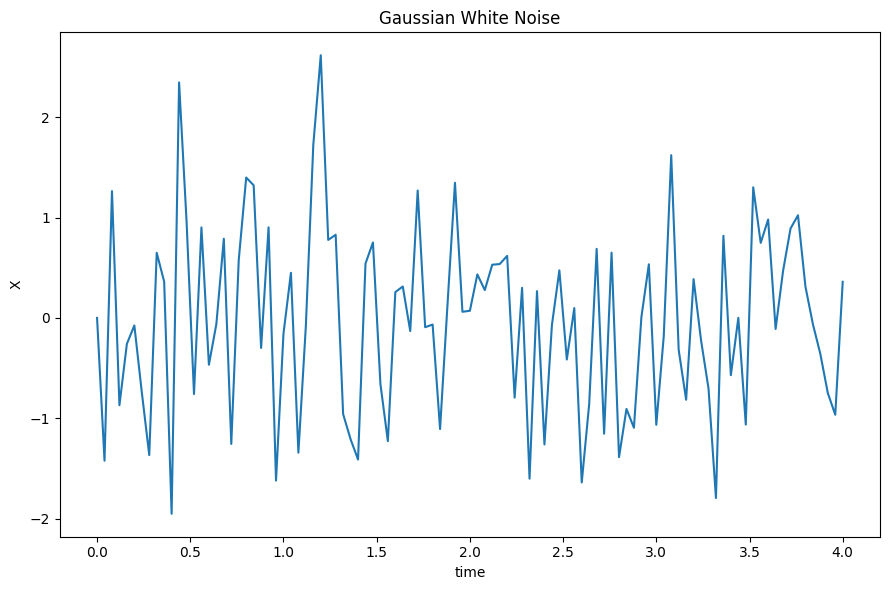

In [4]:
X0 = 0 
T = 4 # Time
Nsteps = 100 # number of steps
Npaths = 1 #number of paths

fig, axes = plt.subplots(1, 1, figsize=(9, 6))


t1, X1 = GaussianWhiteNoise(X0, T, Nsteps, Npaths)
t2, X2 = GaussianWhiteNoise(X0, T, Nsteps, Npaths)
axes.plot(t1, X1)
#axes.plot(t2, X2)
axes.set_title("Gaussian White Noise")
axes.set_xlabel('time')
axes.set_ylabel('X')

plt.tight_layout()
plt.show()

# 2. Weak Stationarity

## 2.1 Stationarity

The foundation of time series analysis is stationarity. There are two types of stationarity: **Strictly Stationarity** and **Weakly Stationarity**. The strict stationarity is really hard to verify empirically becuase it requires an invariant under time shift of its joint distribution of $(r_{t_1}, \dots, r_{t_k})$.

A time series ${r_t}$ is weakly stationarity if both conditions are satisfied.

1. $E(r_t) = \mu$, which is a constant
2. $Cov(r_t, r_{t-l}) = \gamma_l$, which only depends on $l$

In practice, suppose that we have observed $T$ data points $\{r_t | t=1, \dots, T\}$. The weak stationarity implies that the time plot of the data would show that the $T$ values fluctuate with constant variation around a fixed level.

$\gamma_l = Cov(r_t, r_{t-l})$ is called the **lag-$l$ autocovariance** of $r_t$. It has two important properties:

- $\gamma_0 = Var(r_t)$
- $\gamma_{-l} = \gamma_l$

## 2.2 Correlation and AutoCorrelation Function

### Correlation

The correlation coefficient between two random variables $X$ and $Y$ is defined as:
$$ \rho_{x, y} = \frac{Cov(X, Y)}{\sqrt{Var(X) Var(Y)}} = \frac{E[(X-\mu_x)(Y-\mu_y)]}{\sqrt{E(X-\mu_x)^2 E(Y-\mu_y)^2}}$$

where $\mu_x$ and $\mu_y$ are the mean of $X$ and $Y$, respectively. This coefficient measures the strength of linear dependence of between $X$ and $Y$. It has some properties:

- $-1 \leq \rho_{x, y} \leq 1$
- $\rho_{x,y} = \rho_{y, x}$

The two random variables are uncorrelated if $\rho_{x, y} = 0$. In addition, if both $X$ and $Y$ are drawn from normal distribution, then $\rho_{x, y} = 0 $ if and only if $X$ and $Y$ are independent.

For sample, the correlation can be consistently estimated by its sample counterpart
$$\hat{\rho}_{x, y} = \frac{\sum_{t=1} ^T (x_t - \bar{x})(y_t - \bar{y})}{\sqrt{\sum_{t=1} ^T (x_t - \bar{x})^2 \sum_{t=1} ^T (y_t - \bar{y})^2 }}$$

where $\bar{x} = \sum_{t=1} ^T \frac{x_t}{T}$ and $\bar{y} = \sum_{t=1} ^T \frac{y_t}{T}$ are the sample mean of $X$ and $Y$, respectively.

In [5]:
sample_mean1 = np.mean(X1)
sample_mean2 = np.mean(X2)
sample_sd1 = np.sqrt(np.var(X1))
sample_sd2 = np.sqrt(np.var(X2))

print("Sample Mean of X1: ", round(sample_mean1, 4))
print("Standard Deviation of X1: ", round(sample_sd1, 4))
print("Sample Mean of X2: ", round(sample_mean2, 4))
print("Standard Deviation of X2: ", round(sample_sd2, 4))


Sample Mean of X1:  -0.0279
Standard Deviation of X1:  0.9357
Sample Mean of X2:  0.0345
Standard Deviation of X2:  0.9646


In [6]:
sample_corr = np.sum((X1 - np.mean(X1)) * (X2 - np.mean(X2))) \
            / np.sqrt(np.sum((X1 - np.mean(X1))**2) * np.sum((X2 - np.mean(X2))**2))
print("Sample Correlation: ", round(sample_corr, 8))

Sample Correlation:  -0.09769222


In [7]:
print(np.corrcoef(X1.T, X2.T))

[[ 1.         -0.09769222]
 [-0.09769222  1.        ]]


### Autocorrelation Function (ACF)

The correlation coefficient between $r_t$ and $r_{t-l}$ is called the **lag-$l$ autocorrelation of $r_t$** and is denoted by $\rho_l$.

We define
$$\rho_l =  \frac{Cov(r_t, r_{t-l})}{\sqrt{Var(r_t) Var(r_{t-l})}} 
= \frac{Cov(r_t, r_{t-l})}{Var(r_t)} = \frac{\gamma_l}{\gamma_0}$$

where the property $Var(r_t) = Var(r_{t-l})$ for a weakly stationary series is used. From the definition:

- $\rho_0 = 1$
- $\rho_l = \rho_{-l}$
- $-1 \leq \rho_{l} \leq 1$

A weakly stationarity series $\{r_t\}$ is not serially correlated if and only if $\rho_l = 0$ for all $l > 0$.

In general, the lag-$l$ sample autocorrelation of $r_t$ is defined as
$$ \hat{\rho}_l = \frac{\sum_{t=l+1} ^T (r_t - \bar{r}) (r_{t-l} - \bar{r})}{\sum_{t=1} ^T (r_t - \bar{r})^2}, \;\;\;\;\; 0 \leq l \leq T-1$$

If $\{r_t\}$ is an iid sequence satisfying $E(r_t ^2) < \infty$, then $\hat{\rho}_l$ is asymtotically normal with mean zero and variance $1/T$ for any fixed positive integer $l$.

In [8]:
def lag_autocorr(X, lag):
    
    if lag==0:
        return 1.0
    
    numerator = np.sum((X[lag:] - np.mean(X)) * (X[:-lag] - np.mean(X)))
    denominator = np.sum((X - np.mean(X))** 2)
    return numerator / denominator

acf_manual = [lag_autocorr(X1, i) for i in range(1, 11)]
acf_stats = acf(X1, nlags=10)[1:]

acf_df = pd.DataFrame({
    'Manual ACF': acf_manual,
    'Statsmodels ACF': acf_stats
    }, index=[f'Lag {i}' for i in range(1, 11)])

acf_df

,Manual ACF,Statsmodels ACF
Lag 1,-0.001807,-0.001807
Lag 2,-0.012150,-0.012150
Lag 3,0.040093,0.040093
Lag 4,-0.073708,-0.073708
Lag 5,-0.098775,-0.098775
Lag 6,0.003915,0.003915
Lag 7,0.004883,0.004883
Lag 8,-0.019360,-0.019360
Lag 9,0.043051,0.043051
Lag 10,-0.019681,-0.019681


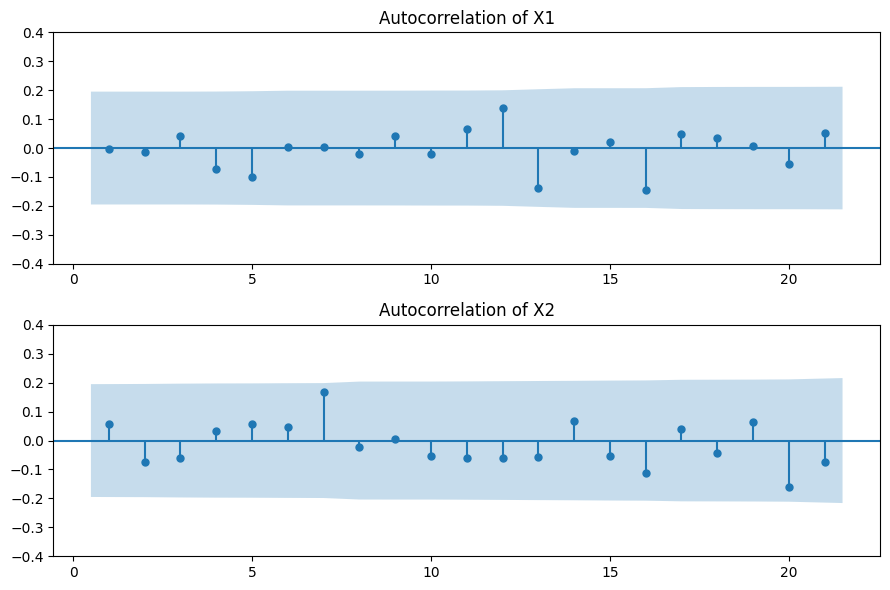

In [9]:
fig, axes = plt.subplots(2, 1, figsize=(9, 6))

plot_acf(X1, ax=axes[0], zero=False)
axes[0].set_ylim(-0.4, 0.4)
axes[0].set_title('Autocorrelation of X1')
plot_acf(X2, ax=axes[1], zero=False)
axes[1].set_ylim(-0.4, 0.4)
axes[1].set_title('Autocorrelation of X2')


plt.tight_layout()
plt.show()

### Ljung and Box

Ljung and Box (1978) proposed the $Q(m)$ statistic as below to test that several autocorrelations of $r_t$ are zero.
$$Q(m) = T (T+2) \sum_{l=1} ^m \frac{\hat{\rho}^2 _l } {T- l }$$

The null hypothesis and altrnative hypthesis is:
- $H_0: \: \rho_1 = \cdots = \rho_m = 0$.
- $H_a: \rho_i \neq 0$ for some $i \in \{1, \dots, m\}$.

The decision rule is to reject $H_0$ if $Q(m) > \chi_\alpha ^2$, where $\chi_\alpha ^2$ denotes the $100(1-\alpha)$th percentile of a chi-squared distribution with $m$ degrees of freedom. If the $p$ value is less than or equal to $\alpha$, the decision rule is then to reject $H_0$.

In practice, the choice of $m$ may affect the performance of the $Q(m)$ statistic. Sumulation studies suggest that the choice of $m \approx \ln(T)$ provides better power performance.

The statistics $\hat{\rho}_1, \hat{\rho}_2, \dots $ is called the **sample autocorrelation function (ACF) of $r_t$**. It plays an important role in linear time series analysis. A linear time series model can be characterised by its ACF, and linear time series modelling makes use of the sample ACF to capture the linear dynamic of the data.

In [10]:
def ljung_box_test(X, m):
    T = len(X)
    rho_hat = acf(X, nlags=m)[1:]
    lags = np.arange(1, m+1)
    Qm = T * (T+2) * np.sum((rho_hat ** 2) / (T - lags))
    p_value = chi2.sf(Qm, m)  # Survival function (1 - CDF) to get the p-value
    return Qm, p_value

In [11]:
results = [ljung_box_test(X1, i) for i in range(1, 11)]
Qm_manual = [res[0] for res in results]
p_values_manual = [res[1] for res in results]

Q_stats = acorr_ljungbox(X1, lags=10)

Q_df = pd.DataFrame({
    'Manual Q(m)': Qm_manual,
    'Statsmodels Q(m)': Q_stats['lb_stat'].values,
    'Manual P-Value': p_values_manual,
    'Statsmodels P-Value': Q_stats['lb_pvalue'].values},
    index = [f'Lag {i}' for i in range(1, 11)])

Q_df

,Manual Q(m),Statsmodels Q(m),Manual P-Value,Statsmodels P-Value
Lag 1,0.000340,0.000340,0.985292,0.985292
Lag 2,0.015853,0.015853,0.992105,0.992105
Lag 3,0.186491,0.186491,0.979740,0.979740
Lag 4,0.769157,0.769157,0.942535,0.942535
Lag 5,1.826424,1.826424,0.872603,0.872603
Lag 6,1.828102,1.828102,0.934810,0.934810
Lag 7,1.830741,1.830741,0.968612,0.968612
Lag 8,1.872668,1.872668,0.984670,0.984670
Lag 9,2.082238,2.082238,0.990099,0.990099
Lag 10,2.126518,2.126518,0.995275,0.995275


The p-values of these test statistics are all greater than 0.05, the 5% significance level, indicating that the values of $X_1$ do not exhibit significant serial correlation. Consequently, we cannot reject the null hypothesis $H_0$.

---

#### Reference:

[1] Tsay, R.S., 2010. Analysis of Financial Time Series. 3rd ed. Hoboken, NJ: Wiley.

[2] Hyndman, R.J. and Athanasopoulos, G., 2018. Forecasting: Principles and Practice. 2nd ed. Melbourne, Australia: OTexts. Available at: https://otexts.com/fpp2/.